Coupon Redemption for Credit Card Campaign
==============

In [77]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
import optuna
import os
from sklearn.model_selection import cross_validate
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_curve, roc_auc_score

In [2]:
colors = sns.color_palette("deep")

# Load Data

In [3]:
data_path = '../data/Predicting Coupon Redemption'
train_df = pd.read_csv(os.path.join(data_path, 'train.csv'))
demo_df = pd.read_csv(os.path.join(data_path, 'customer_demographics.csv'))
cmpn_df = pd.read_csv(os.path.join(data_path, 'campaign_data.csv'))
cp_it_df = pd.read_csv(os.path.join(data_path, 'coupon_item_mapping.csv'))
txn_df = pd.read_csv(os.path.join(data_path, 'customer_transaction_data.csv'))
item_df = pd.read_csv(os.path.join(data_path, 'item_data.csv'))

# Prepare Data

In [4]:
train_df.head()

,id,campaign_id,coupon_id,customer_id,redemption_status
0,1,13,27,1053,0
1,2,13,116,48,0
2,6,9,635,205,0
3,7,13,644,1050,0
4,9,8,1017,1489,0


In [5]:
index_cols = ['campaign_id', 'coupon_id', 'customer_id']
label_col = 'redemption_status'

In [6]:
print("there are {} unique customers".format(train_df['customer_id'].nunique()))
print("there are {} unique campaigns".format(train_df['campaign_id'].nunique()))
print("there are {} unique coupons".format(train_df['coupon_id'].nunique()))

there are 1428 unique customers
there are 18 unique campaigns
there are 866 unique coupons


## Demographic Feature
Combine train_df with demo_df

In [7]:
join_df = train_df.merge(demo_df, on='customer_id', how='left')
join_df.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,age_range,marital_status,rented,family_size,no_of_children,income_bracket
0,1,13,27,1053,0,46-55,NaN,0.0,1,NaN,5.0
1,2,13,116,48,0,36-45,Married,0.0,2,NaN,3.0
2,6,9,635,205,0,46-55,Married,0.0,2,NaN,7.0
3,7,13,644,1050,0,NaN,NaN,NaN,NaN,NaN,NaN
4,9,8,1017,1489,0,46-55,Married,0.0,2,NaN,3.0


In [8]:
feat_cols = ['age_range', 'marital_status', 'rented', 'family_size', 'no_of_children', 'income_bracket']
cat_cols = ['age_range', 'marital_status','family_size', 'no_of_children']
numer_cols = ['rented', 'income_bracket']

## Campaign Data Feature
Combine with campaign data

In [9]:
cmpn_df['start_date'] = cmpn_df['start_date'].apply(pd.to_datetime)
cmpn_df['end_date'] = cmpn_df['end_date'].apply(pd.to_datetime)
cmpn_df['campaign_duration'] = (cmpn_df['end_date'] - cmpn_df['start_date']).astype('timedelta64[D]').astype(int)

In [10]:
join_df = join_df.merge(cmpn_df, on='campaign_id', how='left')
join_df.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,age_range,marital_status,rented,family_size,no_of_children,income_bracket,campaign_type,start_date,end_date,campaign_duration
0,1,13,27,1053,0,46-55,NaN,0.0,1,NaN,5.0,X,2013-05-19,2013-05-07,-12
1,2,13,116,48,0,36-45,Married,0.0,2,NaN,3.0,X,2013-05-19,2013-05-07,-12
2,6,9,635,205,0,46-55,Married,0.0,2,NaN,7.0,Y,2013-11-03,2013-12-04,31
3,7,13,644,1050,0,NaN,NaN,NaN,NaN,NaN,NaN,X,2013-05-19,2013-05-07,-12
4,9,8,1017,1489,0,46-55,Married,0.0,2,NaN,3.0,X,2013-02-16,2013-05-04,77


In [11]:
feat_cols.extend(['campaign_type', 'campaign_duration'])
cat_cols.append('campaign_type')
numer_cols.append('campaign_duration')

## Coupon and Item Feature
Combine with coupon and item data

In [12]:
coupon_df = cp_it_df.merge(item_df, on='item_id', how='left')
coupon_df.head()

,coupon_id,item_id,brand,brand_type,category
0,105,37,56,Local,Grocery
1,107,75,56,Local,Grocery
2,494,76,209,Established,Grocery
3,522,77,278,Established,Grocery
4,518,77,278,Established,Grocery


In [13]:
# aggregate by coupon_id
agg_coupon_df = coupon_df.groupby('coupon_id').agg({'item_id': 'unique', 'category': 'unique', 'brand_type': 'unique', 'brand': 'unique'} )
agg_coupon_df['n_items'] = agg_coupon_df['item_id'].str.len()
agg_coupon_df['n_categories'] = agg_coupon_df['category'].str.len()
agg_coupon_df['n_brand_types'] = agg_coupon_df['brand_type'].str.len()
agg_coupon_df['n_brands'] = agg_coupon_df['brand'].str.len()
agg_coupon_df['brand_type'] = agg_coupon_df['brand_type'].apply(np.sort)
agg_coupon_df['brand_type'] = agg_coupon_df['brand_type'].str.join("/")
agg_coupon_df.reset_index(inplace=True)
print(agg_coupon_df.shape)

# create categories multi-label columns for each coupon 
mlb = MultiLabelBinarizer()
coupon_cats = mlb.fit_transform(agg_coupon_df['category'])
coupon_cat_df = pd.DataFrame(np.column_stack(list(zip(*coupon_cats))), columns=mlb.classes_)
print(coupon_cat_df.shape)
final_coupon_df = pd.concat([agg_coupon_df, coupon_cat_df], axis=1)

(1116, 9)
(1116, 17)


In [14]:
final_coupon_df.columns

Index(['coupon_id', 'item_id', 'category', 'brand_type', 'brand', 'n_items',
       'n_categories', 'n_brand_types', 'n_brands', 'Bakery',
       'Dairy, Juices & Snacks', 'Flowers & Plants', 'Garden', 'Grocery',
       'Meat', 'Miscellaneous', 'Natural Products', 'Packaged Meat',
       'Pharmaceutical', 'Prepared Food', 'Restauarant', 'Salads', 'Seafood',
       'Skin & Hair Care', 'Travel', 'Vegetables (cut)'],
      dtype='object')

In [15]:
column_nm = final_coupon_df.columns
new_column_nm = [re.sub("[^A-Za-z0-9_ ]", "", col) for col in column_nm]
new_column_nm = [re.sub('\s+', "_", col) for col in new_column_nm]
final_coupon_df.columns = new_column_nm

In [18]:
final_coupon_df.head(3)

,coupon_id,item_id,category,brand_type,brand,n_items,n_categories,n_brand_types,n_brands,Bakery,...,Natural_Products,Packaged_Meat,Pharmaceutical,Prepared_Food,Restauarant,Salads,Seafood,Skin_Hair_Care,Travel,Vegetables_cut
0,1,"[60068, 50199, 17091, 44112, 44868, 51028, 592...","[Natural Products, Grocery]",Established,"[4700, 1475, 1558]",39,2,1,3,0,...,1,0,0,0,0,0,0,0,0,0
1,2,"[2581, 12901]",[Grocery],Established,[2084],2,1,1,1,0,...,0,0,0,0,0,0,0,0,0,0
2,3,"[58906, 58943, 58944, 58946, 58964, 58972, 590...",[Grocery],Established,"[1558, 278]",17,1,1,2,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
final_coupon_df.columns

Index(['coupon_id', 'item_id', 'category', 'brand_type', 'brand', 'n_items',
       'n_categories', 'n_brand_types', 'n_brands', 'Bakery',
       'Dairy_Juices_Snacks', 'Flowers_Plants', 'Garden', 'Grocery', 'Meat',
       'Miscellaneous', 'Natural_Products', 'Packaged_Meat', 'Pharmaceutical',
       'Prepared_Food', 'Restauarant', 'Salads', 'Seafood', 'Skin_Hair_Care',
       'Travel', 'Vegetables_cut'],
      dtype='object')

In [19]:
select_cols = ['coupon_id', 'brand_type', 'n_items', 'n_categories', 'n_brand_types', 'n_brands', 
               'Bakery', 'Dairy_Juices_Snacks', 'Flowers_Plants', 'Garden', 'Grocery', 'Meat', 
               'Miscellaneous', 'Natural_Products', 'Packaged_Meat', 'Pharmaceutical', 'Prepared_Food', 
               'Restauarant', 'Salads', 'Seafood', 'Skin_Hair_Care', 'Travel', 'Vegetables_cut']
join_df = join_df.merge(final_coupon_df[select_cols], on='coupon_id', how='left')
join_df.shape

(78369, 37)

In [20]:
feat_cols.extend(['brand_type', 'n_items', 'n_categories', 'n_brand_types', 'n_brands', 
                  'Bakery', 'Dairy_Juices_Snacks', 'Flowers_Plants', 'Garden', 'Grocery', 'Meat', 
                  'Miscellaneous', 'Natural_Products', 'Packaged_Meat', 'Pharmaceutical', 'Prepared_Food', 
                  'Restauarant', 'Salads', 'Seafood', 'Skin_Hair_Care', 'Travel', 'Vegetables_cut'])
cat_cols.extend(['brand_type'])
numer_cols.extend(['n_items', 'n_categories', 'n_brand_types', 'n_brands',
                   'Bakery', 'Dairy_Juices_Snacks', 'Flowers_Plants', 'Garden', 'Grocery', 'Meat', 
                  'Miscellaneous', 'Natural_Products', 'Packaged_Meat', 'Pharmaceutical', 'Prepared_Food', 
                  'Restauarant', 'Salads', 'Seafood', 'Skin_Hair_Care', 'Travel', 'Vegetables_cut'])

## Transaction Data Feature
Combine with transaction history

In [21]:
txn_df['date'] = txn_df['date'].apply(pd.to_datetime)
txn_cmpn_df = train_df.merge(cmpn_df[['campaign_id', 'start_date']], on='campaign_id', how='left')
txn_cmpn_df.head()

,id,campaign_id,coupon_id,customer_id,redemption_status,start_date
0,1,13,27,1053,0,2013-05-19
1,2,13,116,48,0,2013-05-19
2,6,9,635,205,0,2013-11-03
3,7,13,644,1050,0,2013-05-19
4,9,8,1017,1489,0,2013-02-16


In [22]:
join_txn = txn_df.merge(txn_cmpn_df[['customer_id', 'campaign_id', 'start_date']], on='customer_id', how='left')
join_txn = join_txn[~join_txn.duplicated()]
join_txn['date_diff'] = (join_txn['start_date'] - join_txn['date']).dt.days
join_txn.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,campaign_id,start_date,date_diff
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0,13.0,2013-05-19,503.0
14,2012-01-02,1501,54253,1,53.43,-13.89,0.0,13.0,2013-05-19,503.0
28,2012-01-02,1501,31962,1,106.50,-14.25,0.0,13.0,2013-05-19,503.0
42,2012-01-02,1501,33647,1,67.32,0.00,0.0,13.0,2013-05-19,503.0
56,2012-01-02,1501,48199,1,71.24,-28.14,0.0,13.0,2013-05-19,503.0


### aggregate by amount and number of txn

In [23]:
# create column to discretize the transaction data based on the time period before the start date of the campaign
join_txn['date_diff_bin'] = pd.cut(join_txn['date_diff'], bins=[0, 30, 60, 90, 120, 150, 180], 
                                   labels=['P1M','P2M','P3M','P4M','P5M','P6M'])

agg_txn = pd.pivot_table(data=join_txn, 
               values=['quantity','selling_price', 'other_discount', 'coupon_discount'], 
               index=['customer_id', 'campaign_id'],
               columns=['date_diff_bin'],
               aggfunc=np.sum
              )
agg_txn.columns = agg_txn.columns.to_series().str.join('_')
agg_txn = agg_txn.reset_index()
agg_nbr_txn = pd.pivot_table(data=join_txn, 
               values=['item_id'], 
               index=['customer_id', 'campaign_id'],
               columns=['date_diff_bin'],
               aggfunc='count'
              )
agg_nbr_txn.rename({'item_id': 'item_nbr'}, axis=1, inplace=True)
agg_nbr_txn.columns = agg_nbr_txn.columns.to_series().str.join('_')
agg_nbr_txn = agg_nbr_txn.reset_index()

In [24]:
cols = list(agg_txn.columns[2:])
join_df = join_df.merge(agg_txn, on=['customer_id', 'campaign_id'], how='left')
feat_cols.extend(cols)
numer_cols.extend(cols)

In [25]:
cols = list(agg_nbr_txn.columns[2:])
join_df = join_df.merge(agg_nbr_txn, on=['customer_id', 'campaign_id'], how='left')
feat_cols.extend(cols)
numer_cols.extend(cols)

### aggregate by brand and category

In [26]:
join_txn = join_txn.merge(item_df, on='item_id', how='left')
join_txn.head()

,date,customer_id,item_id,quantity,selling_price,other_discount,coupon_discount,campaign_id,start_date,date_diff,date_diff_bin,brand,brand_type,category
0,2012-01-02,1501,26830,1,35.26,-10.69,0.0,13.0,2013-05-19,503.0,NaN,56,Local,Natural Products
1,2012-01-02,1501,54253,1,53.43,-13.89,0.0,13.0,2013-05-19,503.0,NaN,56,Local,Natural Products
2,2012-01-02,1501,31962,1,106.50,-14.25,0.0,13.0,2013-05-19,503.0,NaN,524,Established,Grocery
3,2012-01-02,1501,33647,1,67.32,0.00,0.0,13.0,2013-05-19,503.0,NaN,1134,Established,Grocery
4,2012-01-02,1501,48199,1,71.24,-28.14,0.0,13.0,2013-05-19,503.0,NaN,524,Established,Grocery


In [77]:
agg_brand_txn = pd.pivot_table(data=join_txn, 
                         values=['quantity'], 
                         index=['customer_id', 'campaign_id'],
                         columns=['brand_type', 'date_diff_bin'],
                         aggfunc=np.sum)
agg_brand_txn.columns = agg_brand_txn.columns.to_series().str.join('_')
agg_brand_txn = agg_brand_txn.reset_index()

agg_category_txn = pd.pivot_table(data=join_txn, 
                         values=['quantity'], 
                         index=['customer_id', 'campaign_id'],
                         columns=['category', 'date_diff_bin'],
                         aggfunc=np.sum)
agg_category_txn.columns = agg_category_txn.columns.to_series().str.join('_')
agg_category_txn = agg_category_txn.reset_index()


In [79]:
cols = list(agg_brand_txn.columns[2:])
join_df = join_df.merge(agg_brand_txn, on=['customer_id', 'campaign_id'], how='left')
feat_cols.extend(cols)
numer_cols.extend(cols)

In [98]:
cols = list(agg_category_txn.columns[2:])
join_df = join_df.merge(agg_category_txn, on=['customer_id', 'campaign_id'], how='left')
feat_cols.extend(cols)
numer_cols.extend(cols)

# Split Data for Train and Test

In [62]:
join_df['cmpn_start_mth'] = join_df['start_date'].astype(str).str[:7]

In [63]:
join_df.groupby('cmpn_start_mth').size()

cmpn_start_mth
2012-08     4219
2012-09      476
2012-11     6467
2012-12     7375
2013-01       65
2013-02    24139
2013-04     5332
2013-05    22606
2013-07      972
2013-08     1723
2013-11     3168
2013-12     1827
dtype: int64

In [87]:
cutoff_date = '2013-05-01'
train_df = join_df[join_df['start_date'] < cutoff_date]
test_df = join_df[join_df['start_date'] >= cutoff_date]
print(f'train data size {train_df.shape[0]}')
print(f'test data size {test_df.shape[0]}')

train data size 48073
test data size 30296


In [88]:
X_train = train_df[feat_cols]
y_train = train_df[label_col]
X_test = test_df[feat_cols]
y_test = test_df[label_col]

# Prep Feature

In [89]:
join_df[cat_cols].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78369 entries, 0 to 78368
Data columns (total 6 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   age_range       43661 non-null  object
 1   marital_status  25394 non-null  object
 2   family_size     43661 non-null  object
 3   no_of_children  14056 non-null  object
 4   campaign_type   78369 non-null  object
 5   brand_type      78369 non-null  object
dtypes: object(6)
memory usage: 4.2+ MB


In [90]:
numer_transformer = Pipeline(
    steps=[("imputer", SimpleImputer(strategy="constant", fill_value=0)),
           ("scaler", StandardScaler())
          ]
)

cat_feats = ['Gender', 'Region_Code', 'Occupation', 'Channel_Code']
cat_transformer = OneHotEncoder(handle_unknown='ignore')

transformer = ColumnTransformer(
    transformers=[
        ("num", numer_transformer, numer_cols),
        ("cat", cat_transformer, cat_cols)
    ], sparse_threshold = 0
)

In [91]:
transformer.fit(X_train);

In [92]:
X_train_t = transformer.transform(X_train)
X_test_t = transformer.transform(X_test)

In [93]:
transformers = transformer.get_params()['transformers']
feature_names = []
for name, _, features in transformers:
    try:
        Var = transformer.named_transformers_[name].get_feature_names().tolist()
    except AttributeError:
        Var = features
    feature_names = feature_names + Var

# Model Training

In [119]:
def objective(trial, X, y):
    params = {
        'n_estimators': trial.suggest_int('n_estimators', 10, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 5),
        'max_features': trial.suggest_categorical("max_features", ['sqrt', 'log2']),
        'min_samples_split': trial.suggest_loguniform('min_samples_split', 1e-5, 0.1),
        'min_samples_leaf': trial.suggest_loguniform('min_samples_leaf', 1e-5, 0.1),
        'class_weight': trial.suggest_categorical('class_weight', ['balanced', 'balanced_subsample']),
    }
    clf = RandomForestClassifier(**params, random_state=0)
    score = cross_validate(clf, X, y, cv = 4, scoring = 'roc_auc', return_train_score=True)
    train_score = np.mean(score['train_score'])
    test_score = np.mean(score['test_score'])
    return -(test_score - 0.7 * (train_score - test_score))

In [120]:
#optuna.delete_study(study_name="cc-coupon-redemption", storage="sqlite:///cc-tuning.db")


In [121]:
obj_func = lambda trial: objective(trial, X_train_t, y_train)
train = True
if train:
    study = optuna.create_study(study_name='cc-coupon-redemption', storage='sqlite:///cc-tuning.db', load_if_exists=True)
    study.optimize(obj_func, n_trials=50)
else:
    study = optuna.load_study(study_name='cc-coupon-redemption', storage='sqlite:///../cc-tuning.db')

[I 2022-06-24 18:21:23,155] A new study created in RDB with name: cc-coupon-redemption
[I 2022-06-24 18:21:31,766] Trial 0 finished with value: -0.8215668597687859 and parameters: {'n_estimators': 108, 'max_depth': 4, 'max_features': 'log2', 'min_samples_split': 2.5498676634862613e-05, 'min_samples_leaf': 0.07399192689691342, 'class_weight': 'balanced_subsample'}. Best is trial 0 with value: -0.8215668597687859.
[I 2022-06-24 18:36:59,246] Trial 1 finished with value: -0.8246974958987183 and parameters: {'n_estimators': 342, 'max_depth': 2, 'max_features': 'log2', 'min_samples_split': 0.007373502530410813, 'min_samples_leaf': 0.0002545512537185734, 'class_weight': 'balanced_subsample'}. Best is trial 1 with value: -0.8246974958987183.
[I 2022-06-25 06:22:59,371] Trial 2 finished with value: -0.8246765019962503 and parameters: {'n_estimators': 281, 'max_depth': 2, 'max_features': 'log2', 'min_samples_split': 0.01435116135666584, 'min_samples_leaf': 0.01396472678384449, 'class_weight': '

In [124]:
clf = RandomForestClassifier(**study.best_params)
clf.fit(X_train_t, y_train)

RandomForestClassifier(class_weight='balanced', max_depth=5,
                       max_features='sqrt',
                       min_samples_leaf=0.004878688465406389,
                       min_samples_split=0.0059042390145533, n_estimators=573)

# Model Evaluation

In [129]:
y_train_score = clf.predict_proba(X_train_t)
y_test_score = clf.predict_proba(X_test_t)
y_train_pred = np.where(y_train_score[:, 1] > 0.5, 1, 0)
y_test_pred = np.where(y_test_score[:, 1] > 0.5, 1, 0)


## Classification Report

In [130]:
print("train classification report")
print(classification_report(y_train, y_train_pred))
print("test classification report")
print(classification_report(y_test, y_test_pred))


train classification report
              precision    recall  f1-score   support

           0       1.00      0.86      0.92     47734
           1       0.04      0.84      0.08       339

    accuracy                           0.86     48073
   macro avg       0.52      0.85      0.50     48073
weighted avg       0.99      0.86      0.92     48073

test classification report
              precision    recall  f1-score   support

           0       0.99      0.87      0.93     29906
           1       0.05      0.57      0.10       390

    accuracy                           0.87     30296
   macro avg       0.52      0.72      0.51     30296
weighted avg       0.98      0.87      0.92     30296



## ROCAUC

In [131]:
train_fpr, train_tpr, _ = roc_curve(y_train, y_train_score[:, 1])
test_fpr, test_tpr, _ = roc_curve(y_test, y_test_score[:, 1])

train_auc = roc_auc_score(y_train, y_train_score[:, 1])
test_auc = roc_auc_score(y_test, y_test_score[:, 1])

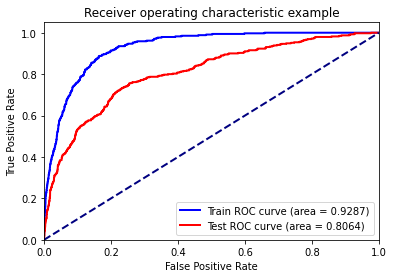

In [132]:
plt.figure()
lw = 2
plt.plot(train_fpr, train_tpr, color="b",lw=lw, label="Train ROC curve (area = %0.4f)" % train_auc)
plt.plot(test_fpr, test_tpr, color="r",lw=lw, label="Test ROC curve (area = %0.4f)" % test_auc)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic example")
plt.legend(loc="lower right")
plt.show()